# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/gdrive",force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/assignment3_starter/assignment3_part1")

#Data Setup

The first thing to do is implement a dataset class to load rotated Imagenette images with matching labels and then we extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [ ]:
import tarfile

tar = tarfile.open("/content/gdrive/MyDrive/assignment3_starter/assignment3_part1/imagenette2-160.tgz","r:gz") #Opens the tar file in read mode
tar.extractall("/tmp") #Extracts the files into the /tmp folder
tar.close()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from PIL import Image
import torchvision.transforms.functional as TF

def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot==1:
      return TF.rotate(img, 90)
    elif rot==2:
      return TF.rotate(img, 180)
    elif rot==3:
      return TF.rotate(img, 270)    
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

class ImagenetteRotation():

    def __init__(self, root, train, download, transform) -> None:
        super().__init__() #root=root, train=train, download=download, transform=transform)
        self.root = root
        self.train = train
        self.transform = transform
        self.download = download

        if self.train:
            self.data_dir = os.path.join(self.root, "train")
        else:
            self.data_dir = os.path.join(self.root, "val")

        self.image_list = []
        self.label_list = []

        # read image files and labels
        for label, label_name in enumerate(sorted(os.listdir(self.data_dir))):
            label_dir = os.path.join(self.data_dir, label_name)
            if not os.path.isdir(label_dir):
              continue  # skip non-directo
            for file_name in os.listdir(label_dir):
                self.image_list.append(os.path.join(label_dir, file_name))
                self.label_list.append(label)
                
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index: int):
        #image, cls_label = super().__getitem__(index)
        
        image_path = self.image_list[index]
        label = self.label_list[index]
        image = Image.open(image_path).convert("RGB")
        #image = Image.array(pil_image) # 
        image = self.transform(image)
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(label).long()

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define the normalization transform
normalize = transforms.Normalize(
    mean=[0,0,0],
    std=[0,0,0]
)

batch_size = 16

trainset = ImagenetteRotation(root='/tmp/imagenette2-160/', 
                              train=True,
                              download=False,
                              transform=transforms.Compose([transforms.Resize(224),
    transforms.CenterCrop(224),transforms.ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)


# Compute the mean and standard deviation of pixel values
mean = 0.
std = 0.
num_samples = 0.
for data, images_rotated, labels, cls_labels in trainloader:
    batch_size = data.size(0)
    data = data.view(batch_size, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    num_samples += batch_size
mean /= num_samples
std /= num_samples

# Print the mean and standard deviation
print(mean)  # [0.4666, 0.4588, 0.4301]
print(std)   # [0.2330, 0.2269, 0.2348]


tensor([0.4666, 0.4588, 0.4301])
tensor([0.2330, 0.2269, 0.2348])


In [ ]:
transform_train = transforms.Compose([
    #transforms.RandomCrop(224, padding=4),
    transforms.Resize(160),
    transforms.CenterCrop(160),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4666, 0.4588, 0.4301), (0.2330, 0.2269, 0.2348)),
])

transform_test = transforms.Compose([
    transforms.Resize(160),
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize((0.4666, 0.4588, 0.4301), (0.2330, 0.2269, 0.2348)),
])

batch_size = 32

trainset = ImagenetteRotation(root='/tmp/imagenette2-160/', train=True,
                                        download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = ImagenetteRotation(root='/tmp/imagenette2-160/', train=False,
                                       download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

Show some example images and rotated images with labels:

In [ ]:
import matplotlib.pyplot as plt

classes = ('n01440764','n02102040','n02979186','n03000684','n03028079','n03394916','n03417042','n03425413','n03445777','n03888257')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img) #Whitening the input image,it reduces the effect of variations in brightness and contrast between images.
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img) #rescaling the pixel values back to their original range of [0, 255]
    #These values correspond to the mean and standard deviation of the imagenette dataset, and are used to 
    #normalize the pixel values so that they have a mean of 0 and a standard deviation of 1.
    npimg = img.numpy() #converts the image tensor to a NumPy array 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  #transposes the dimensions so that the image is in the format (height, width, channels) instead of the PyTorch format (channels, height, width)
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)


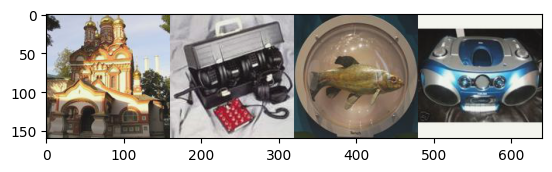

Class labels:  n03394916 n03000684 n02102040 n03000684


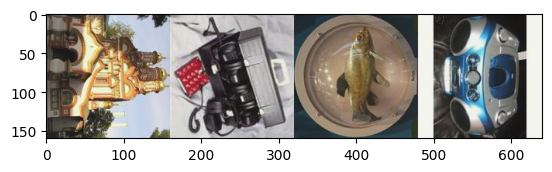

Rotation labels:  270   270   90    270  


In [ ]:
# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs=net(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
# Both the self-supervised rotation task and supervised Imagenette classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels                      
            if task=="rotation":
              imgs=imgs_rotated.to(device)
              labels=rotation_label.to(device)
            elif task=='classification':
              imgs=imgs.to(device)  
              labels=cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            outputs=net(imgs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            _,predicted = torch.max(outputs.data,1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net,testloader,criterion,task)
    print('Finished Training')

In [ ]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(), 'Imagenette_v3_1.pt')

[1,   100] loss: 1.593 acc: 26.25 time: 17.98
[1,   200] loss: 1.402 acc: 30.28 time: 8.94
TESTING:
Accuracy of the network on the 10000 test images: 41.78 %
Average loss on the 10000 test images: 1.374
[2,   100] loss: 1.245 acc: 42.62 time: 10.03
[2,   200] loss: 1.229 acc: 42.72 time: 8.80
TESTING:
Accuracy of the network on the 10000 test images: 45.32 %
Average loss on the 10000 test images: 1.194
[3,   100] loss: 1.199 acc: 45.16 time: 9.96
[3,   200] loss: 1.200 acc: 44.62 time: 8.97
TESTING:
Accuracy of the network on the 10000 test images: 46.98 %
Average loss on the 10000 test images: 1.158
[4,   100] loss: 1.179 acc: 46.62 time: 9.13
[4,   200] loss: 1.168 acc: 46.62 time: 11.28
TESTING:
Accuracy of the network on the 10000 test images: 46.85 %
Average loss on the 10000 test images: 1.165
[5,   100] loss: 1.169 acc: 47.25 time: 9.11
[5,   200] loss: 1.161 acc: 47.84 time: 10.17
TESTING:
Accuracy of the network on the 10000 test images: 47.72 %
Average loss on the 10000 test 

In [ ]:
model_path = 'Imagenette_v3_1.pt'
net.load_state_dict(torch.load(model_path))

optimizer=optim.Adam(net.parameters(),lr=0.01)

train(net, criterion, optimizer, num_epochs=10, decay_epochs=5, init_lr=0.001, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(), 'Imagenette_v3_2.pt')

[1,   100] loss: 1.004 acc: 55.28 time: 9.44
[1,   200] loss: 0.990 acc: 56.44 time: 9.79
TESTING:
Accuracy of the network on the 10000 test images: 54.98 %
Average loss on the 10000 test images: 1.024
[2,   100] loss: 0.990 acc: 57.41 time: 8.79
[2,   200] loss: 0.978 acc: 56.78 time: 9.87
TESTING:
Accuracy of the network on the 10000 test images: 55.21 %
Average loss on the 10000 test images: 1.024
[3,   100] loss: 0.978 acc: 57.50 time: 9.96
[3,   200] loss: 0.974 acc: 56.81 time: 10.12
TESTING:
Accuracy of the network on the 10000 test images: 54.50 %
Average loss on the 10000 test images: 1.028
[4,   100] loss: 0.978 acc: 57.22 time: 10.21
[4,   200] loss: 0.959 acc: 58.22 time: 9.98
TESTING:
Accuracy of the network on the 10000 test images: 55.95 %
Average loss on the 10000 test images: 1.012
[5,   100] loss: 0.960 acc: 58.91 time: 10.19
[5,   200] loss: 0.960 acc: 58.88 time: 9.55
TESTING:
Accuracy of the network on the 10000 test images: 56.38 %
Average loss on the 10000 test i

In [ ]:
model_path = 'Imagenette_v3_2.pt'
net.load_state_dict(torch.load(model_path))

optimizer=optim.Adam(net.parameters(),lr=0.01)

train(net, criterion, optimizer, num_epochs=10, decay_epochs=5, init_lr=0.001, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(), 'Imagenette_v3_3.pt')

[1,   100] loss: 0.926 acc: 59.88 time: 10.17
[1,   200] loss: 0.947 acc: 59.56 time: 9.39
TESTING:
Accuracy of the network on the 10000 test images: 55.87 %
Average loss on the 10000 test images: 1.006
[2,   100] loss: 0.916 acc: 60.69 time: 10.20
[2,   200] loss: 0.972 acc: 57.69 time: 8.81
TESTING:
Accuracy of the network on the 10000 test images: 55.41 %
Average loss on the 10000 test images: 1.009
[3,   100] loss: 0.915 acc: 61.03 time: 9.29
[3,   200] loss: 0.931 acc: 60.09 time: 9.75
TESTING:
Accuracy of the network on the 10000 test images: 57.55 %
Average loss on the 10000 test images: 0.999
[4,   100] loss: 0.923 acc: 61.19 time: 9.07
[4,   200] loss: 0.937 acc: 60.09 time: 10.10
TESTING:
Accuracy of the network on the 10000 test images: 57.61 %
Average loss on the 10000 test images: 1.002
[5,   100] loss: 0.898 acc: 61.34 time: 10.23
[5,   200] loss: 0.924 acc: 60.59 time: 10.07
TESTING:
Accuracy of the network on the 10000 test images: 56.46 %
Average loss on the 10000 test